In [109]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [110]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.keras'

# 分類数設定

In [111]:
NUM_CLASSES = 3

# 入力長

In [112]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [113]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [114]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [116]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

c:\Users\asus\Desktop\web carebuddy\webvenv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [117]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,075 (4.20 KB)

 Trainable params: 1,075 (4.20 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [119]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [120]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 7s 750ms/step - accuracy: 0.4219 - loss: 1.0990
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8455 - loss: 1.0739 - val_accuracy: 0.8960 - val_loss: 1.0446
Epoch 2/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8672 - loss: 1.0514
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8987 - loss: 1.0262 - val_accuracy: 0.9049 - val_loss: 0.9962
Epoch 3/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9062 - loss: 0.9979
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8914 - loss: 0.9812 - val_accuracy: 0.9137 - val_loss: 0.9457
Epoch 4/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8828 - loss: 0.9413
Epoch 4: saving model to model/point_histo

In [121]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [122]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[5.252537e-29 1.000000e+00 7.515232e-26]
1


# 混同行列

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


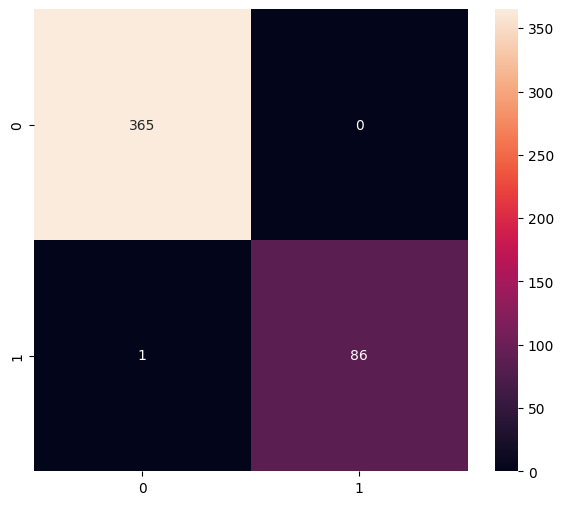

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       365
           1       1.00      0.99      0.99        87

    accuracy                           1.00       452
   macro avg       1.00      0.99      1.00       452
weighted avg       1.00      1.00      1.00       452



In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [124]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [125]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [126]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\asus\AppData\Local\Temp\tmp4cvt870a\assets


INFO:tensorflow:Assets written to: C:\Users\asus\AppData\Local\Temp\tmp4cvt870a\assets


Saved artifact at 'C:\Users\asus\AppData\Local\Temp\tmp4cvt870a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1393931834128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1393931839504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1393931838736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1393931833744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1393931843344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1393931829904: TensorSpec(shape=(), dtype=tf.resource, name=None)


6432

# 推論テスト

In [127]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

c:\Users\asus\Desktop\web carebuddy\webvenv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [128]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_layer_5:0', 'index': 0, 'shape': array([ 1, 32], dtype=int32), 'shape_signature': array([-1, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [129]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [130]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [131]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.252536e-29 1.000000e+00 7.515288e-26]
1
